In [1]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.2 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=747f

# Import Dataset

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="J1rWUvuwvKwOyLI5ooEK")
project = rf.workspace("sanjana-kazi-supti-ymhu2").project("final-1yr0d-wo5ot")
version = project.version(1)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 104.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.3


Extracting Dataset Version Zip to Final-1 in coco:: 100%|██████████| 4295/4295 [00:01<00:00, 3467.75it/s]


# Fix the error in the json file

In [3]:
import json
from pathlib import Path

# ===== Path to your COCO dataset folder =====
dataset_dir = Path("/kaggle/working/Final-1")

# ===== Function to convert JSON to single-class =====
def convert_to_one_class(json_file):
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # Step 1: Keep only one category
    coco_data["categories"] = [{"id": 1, "name": "Sunflower"}]

    # Step 2: Remap all annotations to category_id = 1
    for ann in coco_data["annotations"]:
        ann["category_id"] = 1

    # Step 3: Save back (overwrite original)
    with open(json_file, "w") as f:
        json.dump(coco_data, f, indent=2)

    print(f"Converted: {json_file}")

# ===== Loop over train, valid, test annotation files =====
for split in ["train", "valid", "test"]:
    json_path = dataset_dir / split / "_annotations.coco.json"
    if json_path.exists():
        convert_to_one_class(json_path)
    else:
        print(f"⚠ No JSON file found for {split}")

print("All done! Update YAML with:")
print('nc: 1\nnames: ["Sunflower"]')


Converted: /kaggle/working/Final-1/train/_annotations.coco.json
Converted: /kaggle/working/Final-1/valid/_annotations.coco.json
Converted: /kaggle/working/Final-1/test/_annotations.coco.json
All done! Update YAML with:
nc: 1
names: ["Sunflower"]


# Setup

In [4]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# Path Declaration and COCO --> YOLO Conversion

In [5]:
import json
import shutil
import random
from pathlib import Path
import yaml
from ultralytics import YOLO

# ================================
# 1. Define Paths
# ================================
COCO_ROOT     =  Path("/kaggle/working/Final-1")  # folder with train/ and valid/
TRAIN_IMG_DIR = COCO_ROOT / "train"
TRAIN_ANN     = TRAIN_IMG_DIR / "_annotations.coco.json"
VAL_IMG_DIR   = COCO_ROOT / "valid"
VAL_ANN       = VAL_IMG_DIR / "_annotations.coco.json"

WORK          = Path("/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset")
SPLIT         = WORK / "0_yolo_split"       # YOLO-format dataset split
PSEUDO        = WORK / "1_pseudo"           # Pseudo-label storage
STU_ROOT      = WORK / "2_student"          # Student dataset (GT + pseudo)

# ================================
# 2. Create Folder Structure
# ================================
for split in ["train", "valid", "test"]:
    (SPLIT / split / "images").mkdir(parents=True, exist_ok=True)
    (SPLIT / split / "labels").mkdir(parents=True, exist_ok=True)

(PSEUDO / "raw").mkdir(parents=True, exist_ok=True)

for split in ["train", "valid"]:
    (STU_ROOT / split / "images").mkdir(parents=True, exist_ok=True)
    (STU_ROOT / split / "labels").mkdir(parents=True, exist_ok=True)

# ================================
# 3. Load Classes from COCO
# ================================
cats = json.load(open(TRAIN_ANN))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
nc = len(names)

# ================================
# 4. COCO → YOLO Conversion
# ================================
def coco2yolo(b, w, h):
    x, y, ww, hh = b
    return (x + ww / 2) / w, (y + hh / 2) / h, ww / w, hh / h

def convert_split(split, img_dir, ann_json):
    coco = json.load(open(ann_json))
    id2img = {img["id"]: img for img in coco["images"]}
    out_im = SPLIT / split / "images"
    out_lb = SPLIT / split / "labels"

    # Write YOLO label files
    for ann in coco["annotations"]:
        img = id2img[ann["image_id"]]
        w, h = img["width"], img["height"]
        yb = coco2yolo(ann["bbox"], w, h)
        cls = ann["category_id"] - 1
        p = out_lb / f"{Path(img['file_name']).stem}.txt"
        with open(p, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

    # Copy images
    for img in coco["images"]:
        shutil.copy(Path(img_dir) / img["file_name"], out_im / img["file_name"])

convert_split("train", TRAIN_IMG_DIR, TRAIN_ANN)
convert_split("valid", VAL_IMG_DIR, VAL_ANN)
convert_split("test", TRAIN_IMG_DIR, TRAIN_ANN)  # Use train as test if no separate test set
print("COCO to YOLO conversion completed.")

COCO to YOLO conversion completed.


# Dataset splitting and directory setup for teacher-student training

In [6]:
# ================================
# 5. Split labeled/unlabeled data from 20% labeled portion
# ================================
LABELED_RATIO = 0.1
random.seed(42)

all_train_images = list((SPLIT / "train" / "images").glob("*.jpg"))
random.shuffle(all_train_images)

num_labeled = int(len(all_train_images) * LABELED_RATIO)
labeled_images = all_train_images[:num_labeled]
unlabeled_images = all_train_images[num_labeled:]

print(f"Total train images: {len(all_train_images)}")
print(f"Labeled images (20%): {len(labeled_images)}")
print(f"Unlabeled images (80%): {len(unlabeled_images)}")

# Further split labeled into train (90%) and val (10%)
val_ratio = 0.1
num_val = int(len(labeled_images) * val_ratio)
random.shuffle(labeled_images)
val_images = labeled_images[:num_val]
train_images_for_teacher = labeled_images[num_val:]

print(f"Teacher train images (90% of 20%): {len(train_images_for_teacher)}")
print(f"Teacher val images (10% of 20%): {len(val_images)}")

# Create directories
LABELED_TRAIN_IMG_DIR = WORK / "labeled_train" / "images"
LABELED_TRAIN_LB_DIR  = WORK / "labeled_train" / "labels"
LABELED_VAL_IMG_DIR   = WORK / "labeled_val" / "images"
LABELED_VAL_LB_DIR    = WORK / "labeled_val" / "labels"
UNLABELED_IMG_DIR     = WORK / "unlabeled" / "images"

for d in [LABELED_TRAIN_IMG_DIR, LABELED_TRAIN_LB_DIR, LABELED_VAL_IMG_DIR, LABELED_VAL_LB_DIR, UNLABELED_IMG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Copy train images + labels
for img_path in train_images_for_teacher:
    shutil.copy(img_path, LABELED_TRAIN_IMG_DIR / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, LABELED_TRAIN_LB_DIR / label_path.name)

# Copy val images + labels
for img_path in val_images:
    shutil.copy(img_path, LABELED_VAL_IMG_DIR / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, LABELED_VAL_LB_DIR / label_path.name)

# Copy unlabeled images only
for img_path in unlabeled_images:
    shutil.copy(img_path, UNLABELED_IMG_DIR / img_path.name)

# Copy validation set (from original valid) to STU_ROOT for student eval
(STU_ROOT / "valid" / "images").mkdir(parents=True, exist_ok=True)
(STU_ROOT / "valid" / "labels").mkdir(parents=True, exist_ok=True)
for img in (SPLIT / "valid" / "images").glob("*.*"):
    shutil.copy(img, STU_ROOT / "valid" / "images" / img.name)
    lbl = SPLIT / "valid" / "labels" / f"{img.stem}.txt"
    if lbl.exists():
        shutil.copy(lbl, STU_ROOT / "valid" / "labels" / lbl.name)

# Copy teacher training set to STU_ROOT/train (needed for pseudo-label merging)
(STU_ROOT / "train" / "images").mkdir(parents=True, exist_ok=True)
(STU_ROOT / "train" / "labels").mkdir(parents=True, exist_ok=True)
for img_path in train_images_for_teacher:
    shutil.copy(img_path, STU_ROOT / "train" / "images" / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, STU_ROOT / "train" / "labels" / label_path.name)

print("Data splitting and copying done.")

Total train images: 3957
Labeled images (20%): 395
Unlabeled images (80%): 3562
Teacher train images (90% of 20%): 356
Teacher val images (10% of 20%): 39
Data splitting and copying done.


# Dataset YAML preparation for teacher–student pipeline

In [7]:
# ================================
# 6. Prepare YAML files
# ================================
teacher_data_yaml = {
    'path': str(WORK / "labeled_train"),
    'train': 'images',
    'val': str(LABELED_VAL_IMG_DIR),  # Use absolute path for val
    'nc': nc,
    'names': names
}
teacher_data_yaml_path = WORK / "teacher_data.yaml"
teacher_data_yaml_path.write_text(yaml.dump(teacher_data_yaml))

student_data_yaml = {
    'path': str(STU_ROOT),
    'train': 'train/images',
    'val': 'valid/images',
    'nc': nc,
    'names': names
}
student_data_yaml_path = WORK / "data_Sunflower_student.yaml"
student_data_yaml_path.write_text(yaml.dump(student_data_yaml))

print("YAML files prepared.")

YAML files prepared.


# Two-phase teacher training: freeze backbone, then unfreeze for fine-tuning

In [8]:
# ================================
# 7. Teacher training with frozen backbone then fine-tuning
# ================================

# Use pretrained YOLOv12s instead of local best.pt
teacher = YOLO("yolo12s.pt")  

# Freeze first 25% backbone layers
backbone = teacher.model.model[0]
backbone_layers = list(backbone.children())
total_layers = len(backbone_layers)
freeze_count = int(total_layers * 0.25)
for i, layer in enumerate(backbone_layers):
    if i < freeze_count:
        layer.eval()
        for param in layer.parameters():
            param.requires_grad = False
print(f"Frozen {freeze_count}/{total_layers} backbone layers.")

teacher.train(
    data=str(teacher_data_yaml_path),
    epochs=5,
    imgsz=640,
    batch=12,
    project=str(WORK),
    name="teacher_partial_freeze",
    device=0,
    lr0=0.001,
    lrf=0.1,
    momentum=0.937,
    weight_decay=0.0005,
    cos_lr=True,
    save=True,
)

# Unfreeze all layers for fine-tuning
for param in teacher.model.parameters():
    param.requires_grad = True
print("All layers unfrozen for fine-tuning.")

last_checkpoint = WORK / "teacher_partial_freeze" / "weights" / "last.pt"

teacher.train(
    data=str(teacher_data_yaml_path),
    epochs=50,
    imgsz=640,
    batch=12,
    project=str(WORK),
    name="teacher_final",
    device=0,
    lr0=0.0005,
    lrf=0.05,
    momentum=0.937,
    weight_decay=0.0005,
    cos_lr=True,
    save=True,
    resume=False,
    pretrained=str(last_checkpoint)  # load last checkpoint from frozen phase
)

teacher_weights = WORK / "teacher_final" / "weights" / "best.pt"
print(f"Teacher final model saved to {teacher_weights}")


Frozen 0/3 backbone layers.
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_partial_freeze, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2063.2±967.2 MB/s, size: 93.6 KB)


train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels... 356 images, 0 backgrounds, 0 corrupt: 100%|██████████| 356/356 [00:00<00:00, 1095.32it/s]

train: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 391.1±25.7 MB/s, size: 90.7 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels... 39 images, 0 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<00:00, 1115.13it/s]

val: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.95G      2.016      1.762      1.371        616        640: 100%|██████████| 30/30 [00:12<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         39       3103     0.0366     0.0806     0.0157    0.00703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       6.3G      1.721     0.9918      1.191       1086        640: 100%|██████████| 30/30 [00:10<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         39       3103      0.117      0.426     0.0838     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.08G      1.662     0.9232      1.157       1386        640: 100%|██████████| 30/30 [00:10<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         39       3103      0.738        0.6      0.681      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.12G      1.562     0.8613      1.117        720        640: 100%|██████████| 30/30 [00:10<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         39       3103      0.789      0.738      0.822      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.16G      1.531     0.8328      1.112       1178        640: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         39       3103      0.809      0.739       0.84      0.478



5 epochs completed in 0.018 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]
invalid value encountered in less
invalid value encountered in less


                   all         39       3103      0.809      0.739       0.84      0.477
Speed: 0.2ms preprocess, 8.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze
All layers unfrozen for fine-tuning.
Transferred 691/691 items from pretrained weights
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels.cache... 356 images, 0 backgrounds, 0 corrupt: 100%|██████████| 356/356 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 594.2±501.4 MB/s, size: 90.7 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache... 39 images, 0 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.82G       1.51     0.8123      1.084        616        640: 100%|██████████| 30/30 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         39       3103      0.815      0.615       0.72      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       6.3G      1.526     0.8422      1.101       1086        640: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         39       3103      0.314      0.624      0.264      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.08G      1.626     0.8803      1.128       1386        640: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         39       3103      0.732      0.672      0.701      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.12G      1.618     0.9019      1.135        720        640: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         39       3103      0.273       0.35      0.179     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.16G      1.583       0.88      1.118       1178        640: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         39       3103      0.536      0.317      0.276      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.18G      1.617     0.8804      1.133        950        640: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         39       3103      0.771      0.626      0.712      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.19G      1.568     0.8646      1.114        803        640: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         39       3103      0.774       0.65      0.747      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.23G       1.57     0.8811      1.123        928        640: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         39       3103       0.76      0.717        0.8      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.25G      1.525     0.8512      1.079       1061        640: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         39       3103      0.766      0.757      0.828      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.25G      1.498     0.8206      1.081        933        640: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         39       3103      0.803      0.742      0.833      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.25G      1.523     0.8196      1.087        648        640: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         39       3103      0.814      0.768      0.846       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.25G      1.477     0.8072      1.082        913        640: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         39       3103      0.794       0.76      0.836      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.25G      1.464     0.8049      1.064        787        640: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         39       3103      0.801      0.764      0.842      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.25G      1.504     0.8194      1.089        683        640: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         39       3103      0.814      0.767      0.844      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.25G      1.506     0.8163      1.065       1076        640: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         39       3103      0.789      0.778      0.846      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         8G      1.475     0.7951      1.064        665        640: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         39       3103      0.815      0.794      0.869      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.18G      1.438     0.7735       1.06       1043        640: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         39       3103      0.798       0.78      0.856      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.18G      1.427       0.76       1.06        623        640: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         39       3103      0.783      0.772      0.843      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.94G      1.412     0.7652      1.041        733        640: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         39       3103      0.811      0.772      0.851      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       6.4G      1.418     0.7559      1.047        858        640: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         39       3103      0.819      0.767      0.859       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.07G      1.431     0.7599       1.05        673        640: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         39       3103      0.791      0.777      0.848       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.11G       1.39     0.7383      1.038        710        640: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         39       3103      0.802      0.777      0.853       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.87G      1.408     0.7511      1.048        536        640: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         39       3103      0.812      0.806      0.873      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.86G       1.39     0.7371      1.033        877        640: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         39       3103      0.817      0.785       0.87      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.88G      1.368     0.7284      1.028        570        640: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         39       3103       0.81      0.797      0.873      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.59G      1.365     0.7161      1.015        823        640: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         39       3103       0.82      0.782      0.867      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.63G      1.356     0.7078      1.021        481        640: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         39       3103      0.822      0.784      0.866      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.65G       1.33     0.6978      1.022        965        640: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         39       3103      0.832      0.803      0.883      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.66G      1.353     0.6977      1.028       1005        640: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         39       3103      0.822      0.785      0.871      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.69G      1.346      0.699      1.017        851        640: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         39       3103      0.837      0.789      0.874      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.69G      1.324      0.694      1.015        832        640: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         39       3103      0.833      0.793      0.879      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.69G      1.305     0.6756      1.004        628        640: 100%|██████████| 30/30 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         39       3103      0.824      0.793      0.876      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.69G      1.315     0.6853      1.009        790        640: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         39       3103      0.826      0.791      0.879      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.69G      1.307     0.6657      1.002       1003        640: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         39       3103      0.839      0.785      0.879      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.41G      1.313      0.663     0.9946       1000        640: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         39       3103      0.842      0.798      0.882      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.13G      1.297     0.6604      1.002        592        640: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         39       3103      0.842      0.792      0.882      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.77G       1.29     0.6588      0.996       1193        640: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         39       3103      0.843      0.794      0.884      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.51G      1.269     0.6492      1.001        529        640: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         39       3103       0.83      0.796       0.88      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.08G      1.274     0.6462     0.9903        880        640: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         39       3103      0.827      0.807      0.885      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.75G      1.281     0.6553     0.9996        324        640: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         39       3103      0.836      0.798      0.883      0.524


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.79G       1.27     0.6438      1.004        654        640: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         39       3103      0.812      0.809      0.877      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.83G      1.243     0.6312     0.9932        414        640: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         39       3103      0.831      0.801       0.88      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.87G      1.262     0.6385      1.001        548        640: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         39       3103      0.833      0.804      0.884      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.91G       1.25     0.6338      1.002        784        640: 100%|██████████| 30/30 [00:10<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         39       3103       0.83      0.806      0.878      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.93G      1.237     0.6214     0.9967        505        640: 100%|██████████| 30/30 [00:10<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         39       3103       0.83       0.81      0.884      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.93G       1.25       0.63     0.9977        534        640: 100%|██████████| 30/30 [00:10<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         39       3103      0.838      0.803      0.884      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.93G      1.236     0.6208     0.9932        358        640: 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         39       3103      0.828      0.804      0.881      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.93G      1.226     0.6142     0.9879        668        640: 100%|██████████| 30/30 [00:10<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         39       3103      0.839      0.792      0.884      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.93G      1.217     0.6119     0.9828        620        640: 100%|██████████| 30/30 [00:10<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         39       3103      0.842      0.791      0.881      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.93G      1.203     0.6045     0.9834        544        640: 100%|██████████| 30/30 [00:10<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         39       3103      0.828      0.811      0.885       0.54



50 epochs completed in 0.172 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]
invalid value encountered in less
invalid value encountered in less


                   all         39       3103      0.828      0.811      0.885      0.539
Speed: 0.2ms preprocess, 8.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final
Teacher final model saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt


# Training metrics and result plots for teacher YOLO model

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


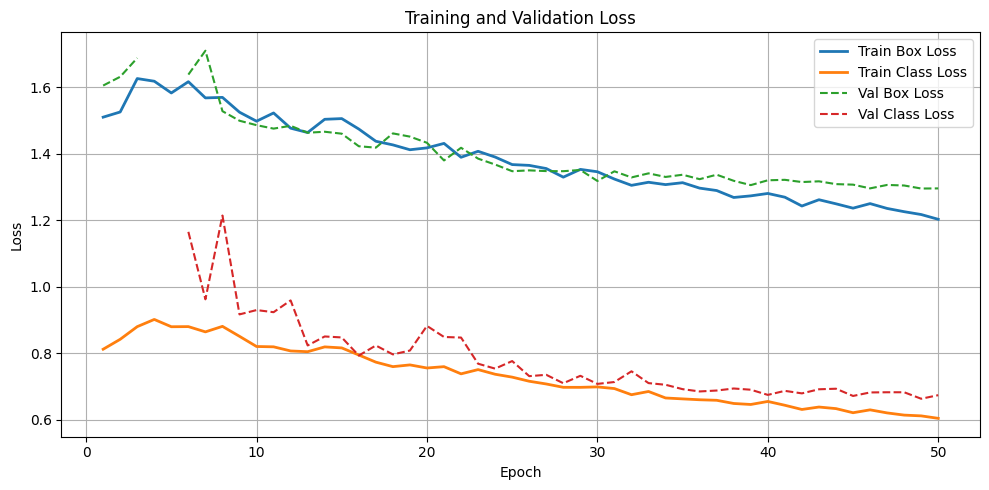

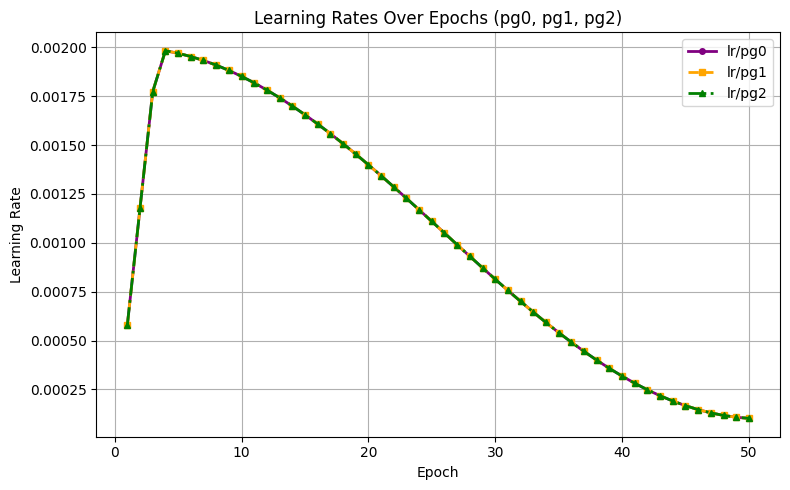

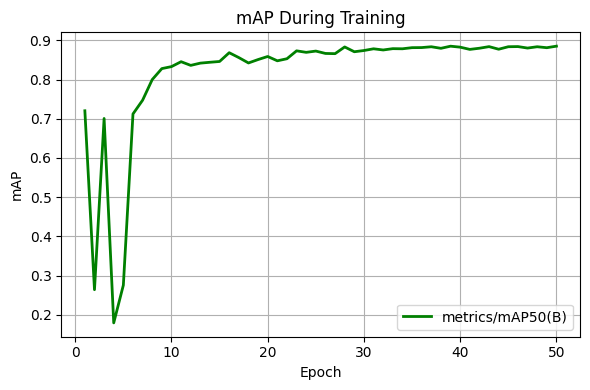

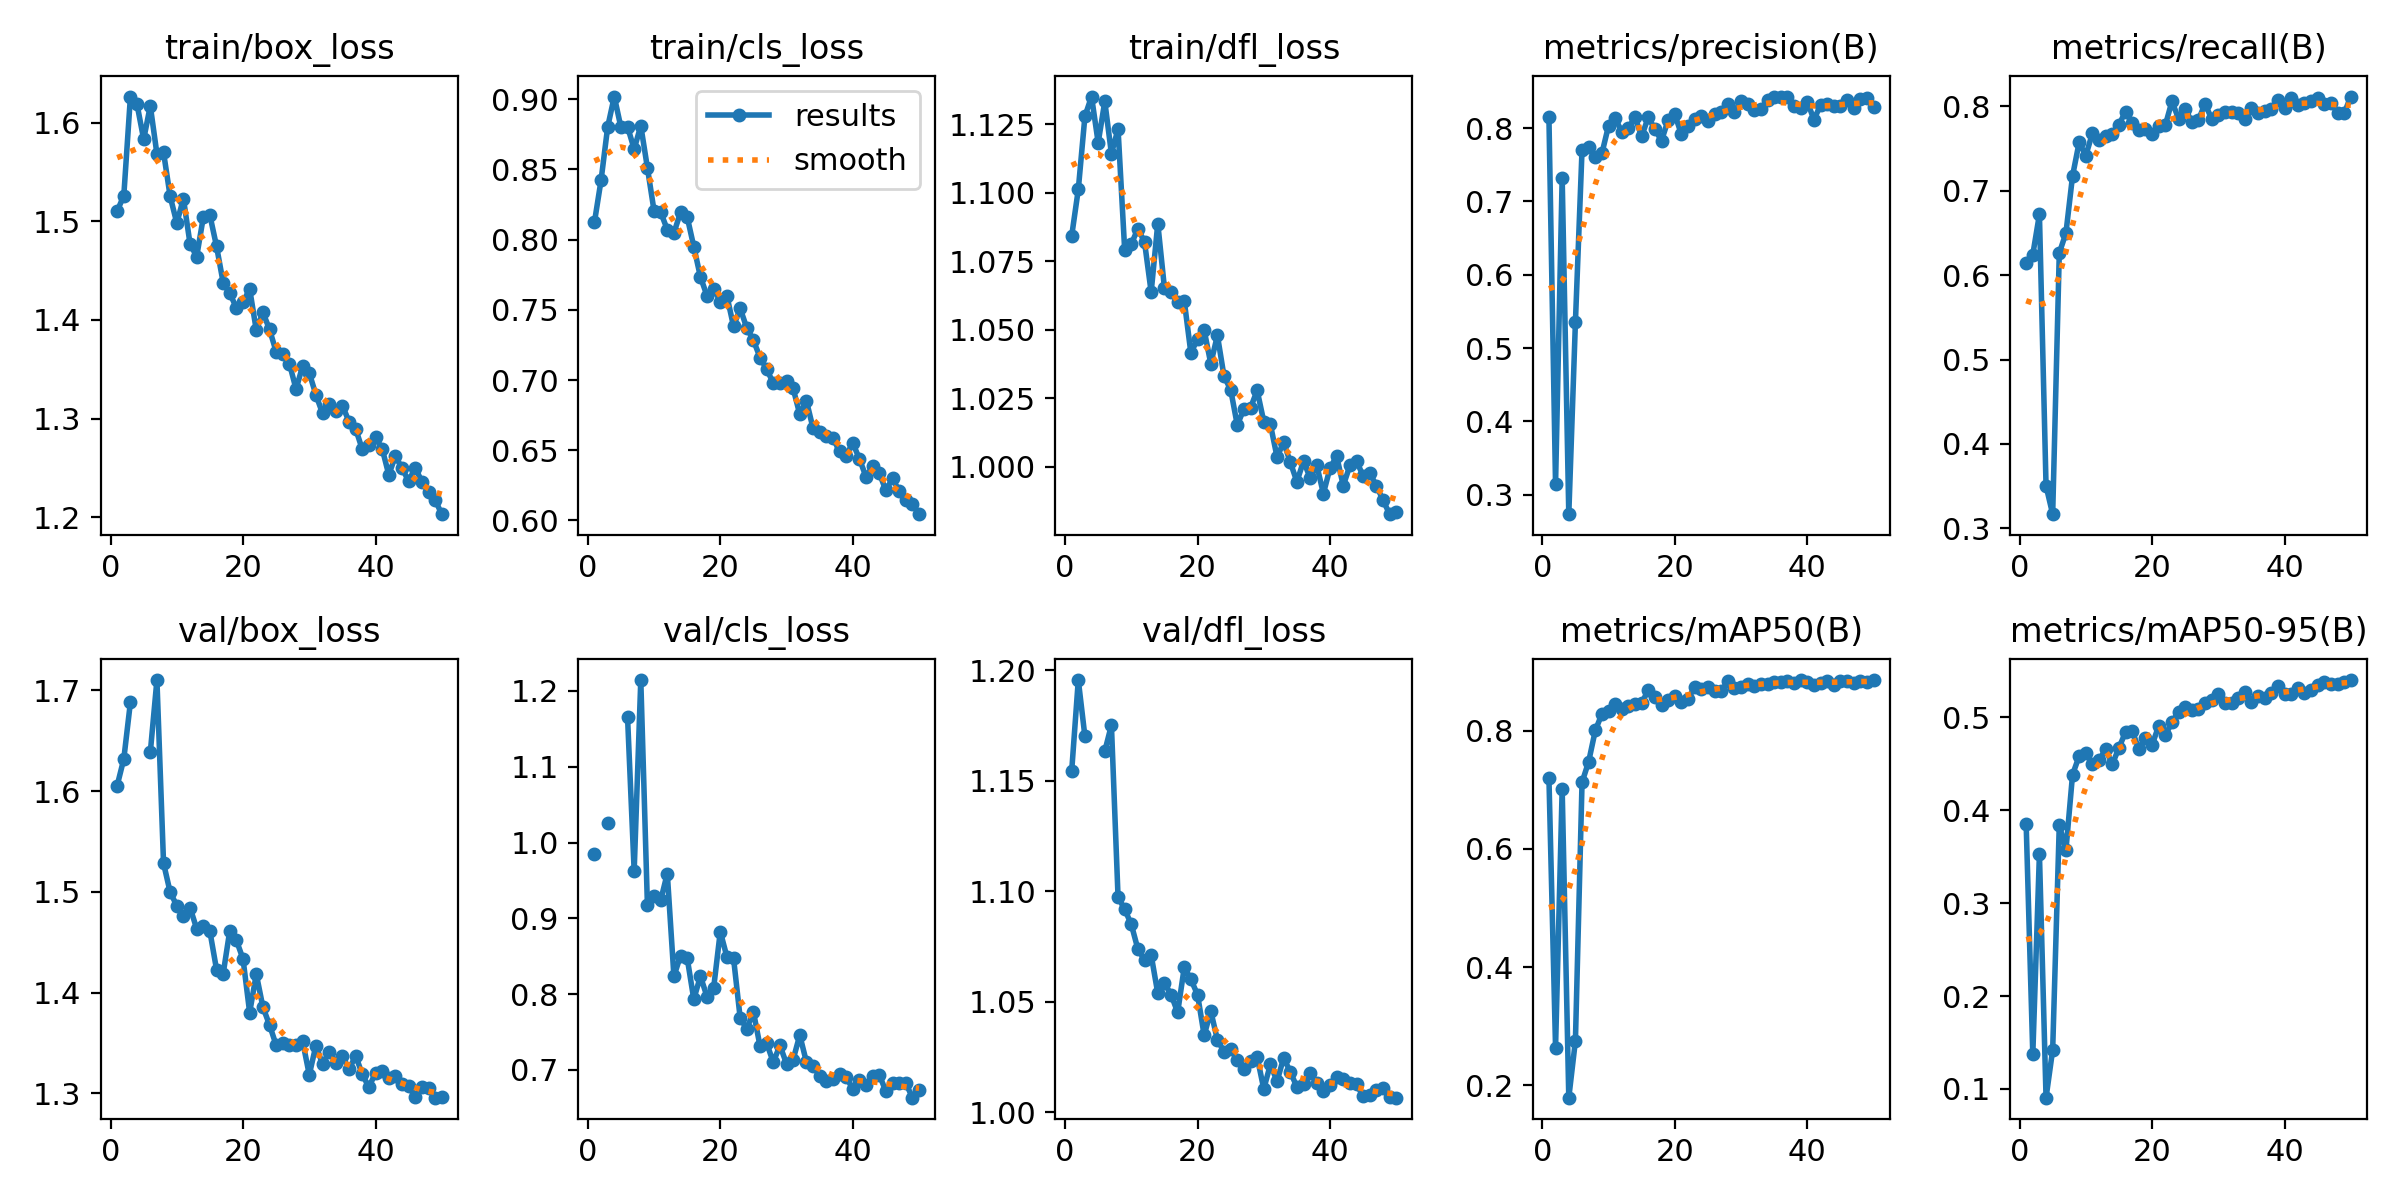

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / "teacher_final" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / "teacher_final" / "results.png"
img = Image.open(results_img)
display(img)

# Semi-supervised training using STAC: teacher generates pseudo-labels, student learns iteratively

In [10]:
# ================================
# 8. STAC-style self-training loop
# ================================
IMGZ = 640
TAU = 0.7
STAC_ITERS = 5
STU_EPOCHS = 50
BATCH = 12
DEVICE = "0"  # Change to "cpu" if no GPU available

print("Starting STAC self-training...")

for it in range(STAC_ITERS):
    print(f"\n=== STAC iteration {it+1}/{STAC_ITERS} ===")

    # 1. Generate pseudo-labels on UNLABELED images
    raw_label_dir = PSEUDO / "raw" / "labels"
    if raw_label_dir.exists():
        shutil.rmtree(raw_label_dir)
    raw_label_dir.mkdir(parents=True, exist_ok=True)

    print(f"Generating pseudo-labels on {len(list(UNLABELED_IMG_DIR.glob('*.*')))} unlabeled images...")
    YOLO(str(teacher_weights)).predict(
        source=str(UNLABELED_IMG_DIR),
        save_txt=True,
        save_conf=True,
        conf=TAU,
        project=str(PSEUDO),
        name="raw",
        device=DEVICE,
        imgsz=IMGZ,
        verbose=True,
    )

    # 2. Prepare student training labels by merging GT + pseudo labels
    labels_dir = STU_ROOT / "train" / "labels"
    # Clear existing student train labels
    for f in labels_dir.glob("*.txt"):
        f.unlink()

    # Copy ground-truth labels from labeled_train (teacher training GT)
    labeled_gt_dir = WORK / "labeled_train" / "labels"
    for gt_file in labeled_gt_dir.glob("*.txt"):
        shutil.copy(gt_file, labels_dir / gt_file.name)

        # If pseudo label exists for same image (only unlabeled images won't have GT)
        pseudo_file = raw_label_dir / gt_file.name
        if pseudo_file.exists():
            with open(labels_dir / gt_file.name, "a") as d, open(pseudo_file, "r") as p:
                d.write(p.read())

    # Add pseudo labels for unlabeled images (which have no GT)
    for pseudo_file in raw_label_dir.glob("*.txt"):
        if not (labels_dir / pseudo_file.name).exists():
            # This pseudo label corresponds to an unlabeled image
            # Copy it directly as student label
            shutil.copy(pseudo_file, labels_dir / pseudo_file.name)

    # Copy labeled + unlabeled images to STU_ROOT/train/images for student training
    # Clear previous images first
    images_dir = STU_ROOT / "train" / "images"
    for f in images_dir.glob("*.*"):
        f.unlink()

    # Copy labeled train images
    labeled_train_images = list((WORK / "labeled_train" / "images").glob("*.*"))
    for img in labeled_train_images:
        shutil.copy(img, images_dir / img.name)

    # Copy unlabeled images (pseudo-labeled) also
    unlabeled_images = list(UNLABELED_IMG_DIR.glob("*.*"))
    for img in unlabeled_images:
        shutil.copy(img, images_dir / img.name)

    print(f"Prepared training set: {len(list(images_dir.glob('*.*')))} images with merged labels.")

    # 3. Train student model on combined dataset
    student = YOLO(str(teacher_weights))
    student.train(
        data=str(WORK / "data_Sunflower_student.yaml"),  # your student YAML path
        epochs=STU_EPOCHS,
        imgsz=IMGZ,
        batch=BATCH,
        project=str(WORK),
        name=f"student_it{it+1}",
        device=DEVICE,
        verbose=True,
    )

    # 4. Update teacher weights to student's best weights for next iteration
    new_teacher_weights = WORK / f"student_it{it+1}" / "weights" / "best.pt"
    if not new_teacher_weights.exists():
        raise FileNotFoundError(f"Student weights not found: {new_teacher_weights}")
    teacher_weights = new_teacher_weights
    print(f"Teacher weights updated to iteration {it+1}'s student best weights.")

print("STAC self-training complete.")

Starting STAC self-training...

=== STAC iteration 1/5 ===
Generating pseudo-labels on 3562 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3562 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/unlabeled/images/20240116_122814-mp4_frame11_jpg.rf.650cefb9416fc89e311a7aff32bdf073.jpg: 640x640 63 Sunflowers, 20.4ms
image 2/3562 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/unlabeled/images/20240116_122814-mp4_frame11_jpg.rf.89dbffb6bc606c0c43f3f6083ba9dd86.jpg: 64

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels... 356 images, 3562 backgrounds, 0 corrupt: 100%|██████████| 3918/3918 [00:01<00:00, 2250.66it/s]

train: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 554.5±396.9 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<00:00, 511.72it/s]

val: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.07G      1.411      48.77      1.059         56        640: 100%|██████████| 327/327 [01:54<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        165      13823      0.256      0.914      0.641      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.87G      1.678      6.176      1.177         67        640: 100%|██████████| 327/327 [01:50<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        165      13823      0.546      0.651      0.599      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.23G      1.689      4.968       1.17          1        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.253      0.869      0.673      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.83G      1.786      4.546      1.264          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.296      0.846        0.7      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.18G      1.781      5.269      1.237         64        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.323      0.851      0.733      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.22G      1.737      4.706      1.229         58        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.292      0.857      0.689      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.25G       1.67      5.085      1.192         33        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.268      0.898      0.773      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.29G      1.698      5.671       1.19          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.286      0.907        0.8      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.33G      1.665      4.557      1.185          6        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823       0.26      0.903       0.78      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.37G      1.663      4.941      1.182         24        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.264      0.862      0.717      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.33G      1.602      5.585      1.157        100        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.351       0.91      0.807      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.33G      1.557      6.325      1.134         15        640: 100%|██████████| 327/327 [01:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.297      0.909      0.773      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.72G       1.55      5.084      1.149        158        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        165      13823      0.451      0.852      0.724       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.76G       1.54      4.201      1.108          8        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.294      0.922      0.809      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.79G      1.545      6.245      1.121         30        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.369      0.922      0.807      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.84G      1.544      6.686      1.126          2        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.292      0.917      0.787       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.87G      1.543      5.615      1.134        175        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.322       0.92      0.757        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.91G      1.529      5.746      1.099         98        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.387      0.885      0.795      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.95G       1.54      4.736      1.105        106        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.374      0.919      0.793      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.99G      1.495      5.373      1.074         10        640: 100%|██████████| 327/327 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.365       0.93       0.82      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.03G      1.485      5.741      1.085        171        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.342      0.933      0.841      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.06G      1.491      5.545      1.102        144        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.376      0.927      0.817      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       6.1G      1.492      5.576      1.102          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.375      0.937      0.839      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.14G      1.457      5.365      1.089          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.339      0.927      0.835      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.18G      1.473      6.547      1.084          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.356      0.933      0.834      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.22G      1.457      5.299      1.096          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.389      0.935      0.834      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.25G      1.404      6.289      1.058         16        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.412      0.928       0.82      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       6.3G       1.41      5.229      1.053         27        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.358      0.939       0.85        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.34G      1.459      4.782      1.086         73        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.385      0.939      0.864      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.38G      1.437       6.81      1.089         37        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.397      0.935      0.847      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.42G      1.367       6.73      1.045         76        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.384      0.937      0.851      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.45G      1.424      4.857       1.07         13        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.413      0.936       0.84      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       6.5G      1.438      5.683      1.092        138        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.391      0.936      0.848      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.99G      1.376      5.802      1.039          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.397      0.939      0.856      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.03G      1.412       5.25      1.066         84        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.378      0.941      0.858      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.07G      1.376      6.246      1.035          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.371      0.942      0.865      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       7.1G      1.317       6.74      1.021          4        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.413      0.938       0.84      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.15G      1.381      5.014      1.057         42        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.389      0.941      0.861      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.19G      1.354      6.947      1.029          5        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.391      0.943      0.854      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.22G      1.374      4.455      1.064        332        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823       0.42      0.941      0.853      0.508


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.26G      1.029      9.008     0.7953          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]

                   all        165      13823      0.932     0.0718        0.5      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.29G     0.9955      3.244     0.7861          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        165      13823      0.978     0.0319      0.505      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.34G     0.9444      3.123     0.7413          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          1   7.23e-05        0.5        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.38G     0.9583      3.196     0.7583         77        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        165      13823          1    0.00152      0.501      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.59G     0.9223      3.122      0.741          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          1   7.23e-05        0.5       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.59G       0.89      3.072     0.7127         50        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.59G     0.8757      3.012     0.6975          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.59G     0.9191      3.136     0.7435          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        165      13823      0.979     0.0101      0.495      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.59G     0.8853      3.074     0.7199        128        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        165      13823      0.974    0.00825      0.491      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.59G     0.9218      3.148     0.7425         75        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        165      13823      0.972     0.0124      0.492      0.375



50 epochs completed in 1.562 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823       0.42      0.941      0.853      0.508
Speed: 0.2ms preprocess, 9.2ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1
Teacher weights updated to iteration 1's student best weights.

=== STAC iteration 2/5 ===
Generating pseudo-labels on 3562 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3562 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_D

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 356 images, 3562 backgrounds, 0 corrupt: 100%|██████████| 3918/3918 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 348.6±186.9 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.93G       1.34      7.304      1.041         56        640: 100%|██████████| 327/327 [01:55<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.394      0.944      0.851      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.24G      1.419      6.317      1.069         67        640: 100%|██████████| 327/327 [01:50<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.361      0.937      0.849      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.24G      1.457      6.794      1.059          1        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        165      13823      0.442      0.908      0.797       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.26G       1.51      4.593      1.125          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.361      0.928      0.802      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.26G      1.502       6.24      1.092         64        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823       0.27      0.931      0.827      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.26G      1.495       5.09      1.117         58        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        165      13823      0.305      0.918      0.797      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.26G      1.474      5.603      1.099         33        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.334      0.934      0.796      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.29G      1.496      6.055      1.097          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.347      0.935      0.851      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.29G      1.484      4.789      1.104          6        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.314      0.926      0.819      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.29G      1.481      5.313      1.097         24        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823       0.35      0.937      0.838      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.29G      1.461      6.063       1.09        100        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.374      0.928      0.835      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.29G       1.44      6.724      1.077         15        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.335      0.939      0.824      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.29G       1.42      5.719      1.079        158        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]

                   all        165      13823      0.451      0.915      0.803      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.29G      1.394      4.838      1.044          8        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.354      0.926      0.823      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.29G      1.415      6.677      1.065         30        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.369      0.941      0.842      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.29G      1.425      6.957      1.068          2        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        165      13823      0.341      0.934      0.835       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.29G      1.425      5.807      1.074        175        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.407      0.922      0.777      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.29G      1.425      6.025      1.055         98        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.387      0.923      0.837      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.29G      1.434      5.005      1.058        106        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.382      0.928      0.814      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.29G      1.403      5.709      1.034         10        640: 100%|██████████| 327/327 [01:50<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.368      0.942      0.828       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.29G      1.391      5.815      1.043        171        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.347       0.94      0.855      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.29G       1.39      5.928      1.061        144        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.402      0.939      0.843       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.29G      1.401      5.774      1.062          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.384       0.94      0.837      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.29G      1.363       5.69       1.05          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.348      0.943       0.85      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.29G      1.392      6.632      1.048          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.377      0.938      0.851      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.29G      1.375      5.662       1.06          0        640: 100%|██████████| 327/327 [01:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.405      0.934      0.844      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.29G      1.318      6.589      1.023         16        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823       0.46      0.933      0.835      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.29G      1.341      5.468      1.023         27        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.388      0.941      0.847      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.29G      1.377      4.687      1.057         73        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.382      0.942      0.856      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.29G      1.364      7.171      1.059         37        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.396      0.941      0.856      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.29G      1.302      7.241      1.018         76        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.386      0.943      0.849      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.29G      1.348      4.899      1.042         13        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.434      0.942      0.846      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.29G      1.354      5.852      1.053        138        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.406       0.94      0.849      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.29G      1.303      6.271      1.007          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.401      0.945      0.858      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.29G      1.339      5.428      1.036         84        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.386      0.942      0.851      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.29G      1.314       6.39       1.01          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.385      0.946      0.861      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.29G      1.259      7.406     0.9964          4        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.408      0.943       0.84      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.29G      1.318      5.176      1.029         42        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.421      0.941      0.863      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.29G        1.3      7.165      1.005          5        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.407      0.944      0.852      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.29G      1.319      4.617      1.044        332        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        165      13823      0.431      0.942      0.849      0.505


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.29G     0.9895      10.57     0.7756          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

                   all        165      13823      0.918     0.0582      0.488      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.29G     0.9623        nan     0.7707          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.29G     0.9185      3.111     0.7294          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.29G     0.9328       3.18     0.7489         77        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.29G     0.9006      3.109     0.7313          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       7.3G     0.8708      3.062     0.7047         50        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       7.3G     0.8551      2.992     0.6902          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       7.3G     0.8989      3.119     0.7369          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       7.3G     0.8667      3.051     0.7133        128        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       7.3G     0.9076      3.127      0.737         75        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



50 epochs completed in 1.561 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.421      0.941      0.863      0.506
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2
Teacher weights updated to iteration 2's student best weights.

=== STAC iteration 3/5 ===
Generating pseudo-labels on 3562 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3562 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 356 images, 3562 backgrounds, 0 corrupt: 100%|██████████| 3918/3918 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 456.2±75.3 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.11G      1.288      7.243      1.021         56        640: 100%|██████████| 327/327 [01:54<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.418      0.945      0.857      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.89G      1.347      6.452       1.04         67        640: 100%|██████████| 327/327 [01:50<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.362      0.941       0.85      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.24G      1.361      7.294      1.021          1        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.352      0.939      0.809      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.86G      1.417      5.149      1.076          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.374      0.937      0.819      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.19G      1.391      6.538      1.046         64        640: 100%|██████████| 327/327 [01:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        165      13823      0.605      0.898       0.84      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.23G      1.412      5.138      1.077         58        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823       0.33       0.92      0.806      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.26G      1.402      5.822      1.064         33        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.382      0.933      0.807      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.26G      1.407      6.102      1.052          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.351      0.938      0.845      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.26G        1.4      4.953      1.061          6        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.319      0.932      0.808      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.26G      1.401      5.377      1.058         24        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.368      0.934      0.844      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.26G      1.392      6.251      1.055        100        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.382      0.928      0.832      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.26G      1.367      6.917      1.045         15        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823       0.36      0.939      0.819      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.26G       1.36      6.152      1.053        158        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.415      0.924      0.805      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.26G      1.332       5.15      1.017          8        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823       0.38      0.936      0.828      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.26G      1.358      6.763      1.038         30        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.388      0.944      0.847      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.26G      1.353      7.033      1.037          2        640: 100%|██████████| 327/327 [01:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.377      0.937      0.838      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.26G      1.364      6.018      1.054        175        640: 100%|██████████| 327/327 [01:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        165      13823      0.425      0.934      0.802      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.26G      1.349      6.268      1.025         98        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.416      0.938      0.853      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.26G      1.359      5.143       1.03        106        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.382      0.943      0.806      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.26G       1.34      5.916      1.009         10        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.371      0.943      0.803       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.26G      1.331      5.887      1.015        171        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.379      0.944      0.859      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.26G        nan        nan        nan        144        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.26G      1.342      5.793      1.036          0        640: 100%|██████████| 327/327 [01:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.26G        nan        nan        nan          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.26G      1.332      6.355      1.023          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.26G      1.317      5.716      1.031          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.26G        nan        nan        nan         16        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.26G        nan        nan        nan         27        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.26G      1.334      4.813      1.039         73        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.26G      1.326      7.436      1.043         37        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.26G      1.277      7.157      1.007         76        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.26G      1.318      5.146      1.026         13        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.27G      1.322      5.941      1.037        138        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       7.3G      1.282      6.402     0.9981          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       7.3G      1.316      5.514      1.025         84        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       7.3G      1.294      6.519      1.001          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       7.3G      1.249      6.812      0.992          4        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       7.3G      1.302       5.26      1.018         42        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       7.3G      1.293       7.43      1.003          5        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       7.3G      1.311      4.581      1.035        332        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       7.3G     0.9642      8.593     0.7674          0        640: 100%|██████████| 327/327 [01:46<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       7.3G      0.953      3.231     0.7673          0        640: 100%|██████████| 327/327 [01:46<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       7.3G     0.9113      3.115     0.7272          0        640: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       7.3G     0.9244      3.194     0.7457         77        640: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       7.3G     0.8964      3.121     0.7307          0        640: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       7.3G     0.8689      3.064     0.7042         50        640: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       7.3G     0.8513          3     0.6898          0        640: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       7.3G     0.8969      3.128     0.7371          0        640: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       7.3G     0.8668      3.067      0.712        128        640: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       7.3G     0.9055      3.149     0.7385         75        640: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



50 epochs completed in 1.547 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.418      0.945      0.857      0.505
Speed: 0.2ms preprocess, 10.3ms inference, 0.0ms loss, 16.7ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3
Teacher weights updated to iteration 3's student best weights.

=== STAC iteration 4/5 ===
Generating pseudo-labels on 3562 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3562 /kaggle/working/PSEUDO_STAC/Pseudo_Converted

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 356 images, 3562 backgrounds, 0 corrupt: 100%|██████████| 3918/3918 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 455.8±48.3 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       6.1G      1.213      7.815     0.9929         56        640: 100%|██████████| 327/327 [01:54<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.438      0.935      0.836      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.89G      1.356      6.482      1.043         67        640: 100%|██████████| 327/327 [01:50<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.373      0.939      0.848      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.25G      1.367      7.167      1.023          1        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.374      0.934      0.824      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.87G      1.415      4.896      1.074          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.358      0.932      0.801      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.19G      1.395      6.571      1.045         64        640: 100%|██████████| 327/327 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.432      0.935       0.85      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.23G      1.412      5.177      1.077         58        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.339      0.933      0.802       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.25G      1.401      5.687      1.063         33        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.356      0.929      0.799      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.25G      1.411      6.115      1.059          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823       0.36      0.933      0.829      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.25G      1.392      4.961      1.059          6        640: 100%|██████████| 327/327 [01:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.339      0.938      0.826      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.26G      1.389      5.383      1.053         24        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.362       0.94       0.84      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.27G        nan        nan        nan        100        640: 100%|██████████| 327/327 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.29G        nan        nan        nan         15        640: 100%|██████████| 327/327 [01:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.29G        nan        nan        nan        158        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.29G      1.348      4.891      1.026          8        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.29G       1.38      6.492      1.046         30        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.29G      1.384      7.525      1.054          2        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.29G      1.382       5.92      1.062        175        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.29G      1.381      6.183      1.036         98        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.29G      1.389      4.973      1.042        106        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.29G      1.375      5.507      1.025         10        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.29G      1.378      6.942      1.034        171        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.29G      1.356      5.834      1.045        144        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.29G      1.382      6.535       1.05          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.29G      1.345       6.17       1.04          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.29G      1.369      6.677      1.044          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.29G      1.351       5.47      1.052          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       7.3G      1.308      6.563      1.015         16        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       7.3G      1.327      5.568      1.013         27        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       7.3G      1.369      4.167      1.049         73        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       7.3G      1.375      7.008      1.062         37        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       7.3G      1.316      7.656      1.024         76        640: 100%|██████████| 327/327 [01:47<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       7.3G      1.353      5.568      1.043         13        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       7.3G      1.365      6.202       1.05        138        640: 100%|██████████| 327/327 [01:46<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       7.3G      1.327      6.504       1.02          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       7.3G      1.347      5.528      1.041         84        640: 100%|██████████| 327/327 [01:46<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       7.3G      1.323      6.652      1.015          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       7.3G      1.278      6.677      1.001          4        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       7.3G      1.332      5.602      1.035         42        640: 100%|██████████| 327/327 [01:47<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.33G      1.334      7.753      1.024          5        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.33G      1.345      4.677      1.052        332        640: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.33G     0.9835      7.542     0.7836          0        640: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.33G     0.9753      3.234      0.784          0        640: 100%|██████████| 327/327 [01:45<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.33G      0.935      3.135     0.7471          0        640: 100%|██████████| 327/327 [01:45<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.33G     0.9507       3.21      0.764         77        640: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.33G     0.9231      3.145     0.7486          0        640: 100%|██████████| 327/327 [01:45<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.33G     0.8954      3.093     0.7206         50        640: 100%|██████████| 327/327 [01:45<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.33G     0.8754      3.024     0.7038          0        640: 100%|██████████| 327/327 [01:45<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.33G     0.9236      3.146     0.7531          0        640: 100%|██████████| 327/327 [01:45<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.33G      0.893      3.092     0.7284        128        640: 100%|██████████| 327/327 [01:45<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.33G     0.9298      3.167     0.7521         75        640: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



50 epochs completed in 1.533 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.452      0.932       0.85      0.497
Speed: 0.2ms preprocess, 10.3ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4
Teacher weights updated to iteration 4's student best weights.

=== STAC iteration 5/5 ===
Generating pseudo-labels on 3562 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3562 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 356 images, 3562 backgrounds, 0 corrupt: 100%|██████████| 3918/3918 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 374.7±209.5 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.09G      1.285      8.565      1.018         56        640: 100%|██████████| 327/327 [01:54<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.433      0.941      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.87G      1.312      6.473      1.024         67        640: 100%|██████████| 327/327 [01:50<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.382       0.94      0.836      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.24G      1.314      7.359      1.006          1        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.373      0.939      0.823       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.85G      1.363       4.91      1.053          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.346      0.932      0.789      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.19G       1.37      6.643      1.031         64        640: 100%|██████████| 327/327 [01:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.408      0.934      0.847      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.22G      1.418      5.167      1.078         58        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.326      0.932      0.807      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.26G      1.397      5.831      1.063         33        640: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.348       0.93      0.789      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.26G      1.408      6.155      1.052          0        640: 100%|██████████| 327/327 [01:49<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

                   all        165      13823      0.366      0.942      0.837      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.26G      1.393      4.959      1.057          6        640: 100%|██████████| 327/327 [01:49<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.361      0.939      0.827      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.26G        nan        nan        nan         24        640: 100%|██████████| 327/327 [01:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.29G      1.394      6.301      1.053        100        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.29G      1.357      6.934      1.038         15        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.29G      1.359      6.036       1.05        158        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.29G      1.339      5.034      1.022          8        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.29G      1.356      6.808      1.037         30        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.29G      1.364      6.901      1.041          2        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.29G      1.368      5.936      1.056        175        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.29G      1.374      6.227       1.03         98        640: 100%|██████████| 327/327 [01:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.29G      1.382       5.16      1.037        106        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.29G      1.351      5.768      1.011         10        640: 100%|██████████| 327/327 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.29G      1.353      6.085      1.023        171        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.29G      1.338      6.019      1.035        144        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.29G      1.352      6.071       1.04          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.29G      1.339      5.805      1.038          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.29G      1.358      6.691      1.036          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.29G      1.339      5.806      1.042          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.29G      1.293      6.745      1.011         16        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.29G      1.308       5.77      1.009         27        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.29G      1.346      4.848      1.044         73        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.29G      1.336      7.439      1.048         37        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.29G      1.281      7.397      1.008         76        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.29G      1.323        5.1       1.03         13        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.29G      1.335      6.018      1.042        138        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.29G       1.29      6.324      1.002          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.29G      1.323      5.526       1.03         84        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.29G      1.301      6.585      1.005          0        640: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.29G       1.25      7.209     0.9909          4        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.29G        1.3      5.308      1.019         42        640: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.29G      1.289      7.669      1.001          5        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.29G       1.31      4.728      1.034        332        640: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.29G     0.9702      10.18     0.7721          0        640: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.29G     0.9567      3.227     0.7748          0        640: 100%|██████████| 327/327 [01:46<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.29G     0.9128      3.117     0.7313          0        640: 100%|██████████| 327/327 [01:46<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.29G     0.9316      3.192     0.7495         77        640: 100%|██████████| 327/327 [01:46<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.29G     0.8992      3.124      0.731          0        640: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.29G      0.871      3.076     0.7052         50        640: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.29G     0.8559      3.002     0.6897          0        640: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.29G     0.9014      3.131     0.7375          0        640: 100%|██████████| 327/327 [01:46<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.29G     0.8679      3.068     0.7121        128        640: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.29G     0.9074      3.144      0.739         75        640: 100%|██████████| 327/327 [01:46<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        165      13823          0          0          0          0



50 epochs completed in 1.541 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.433      0.941      0.841      0.495
Speed: 0.2ms preprocess, 8.3ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5
Teacher weights updated to iteration 5's student best weights.
STAC self-training complete.


# Visualization of Student Training Results

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


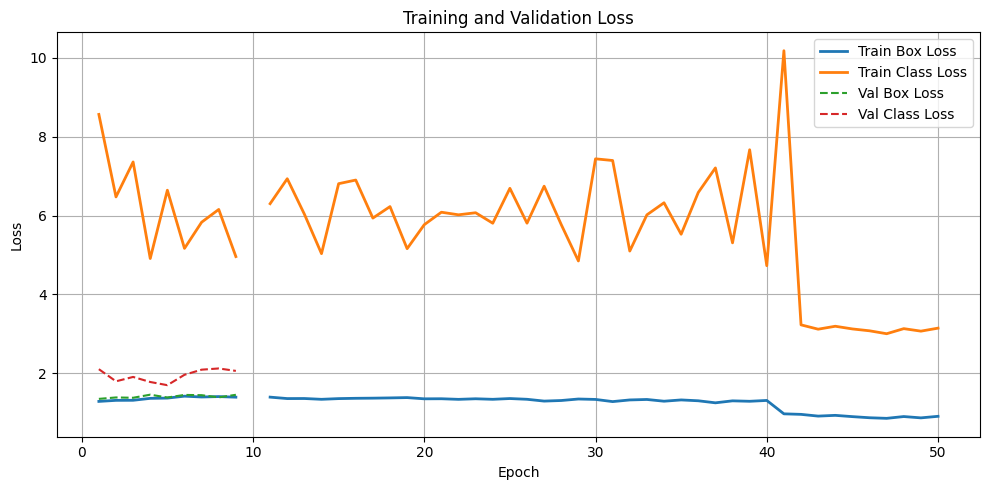

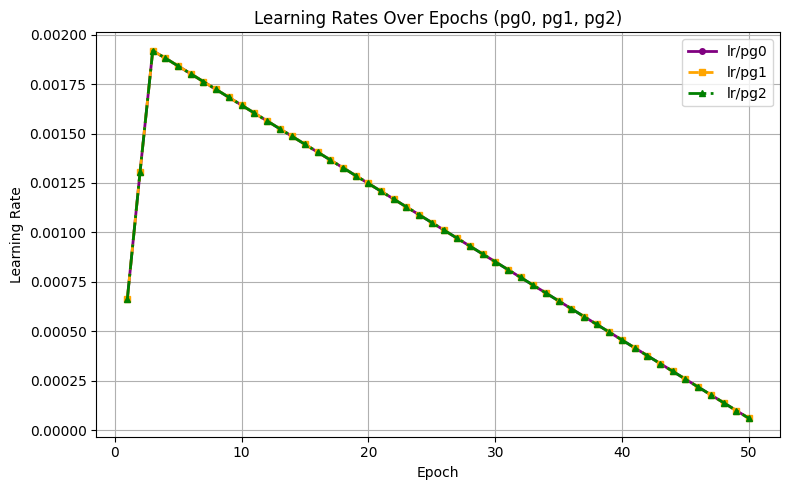

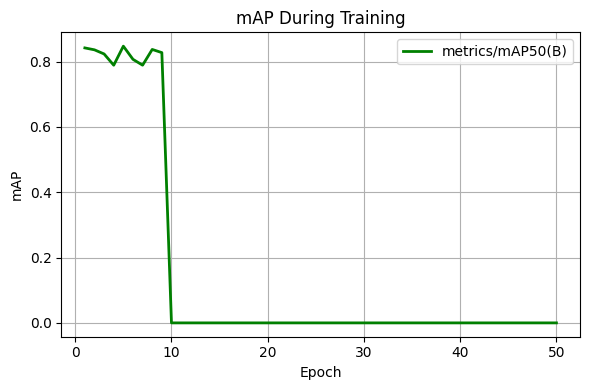

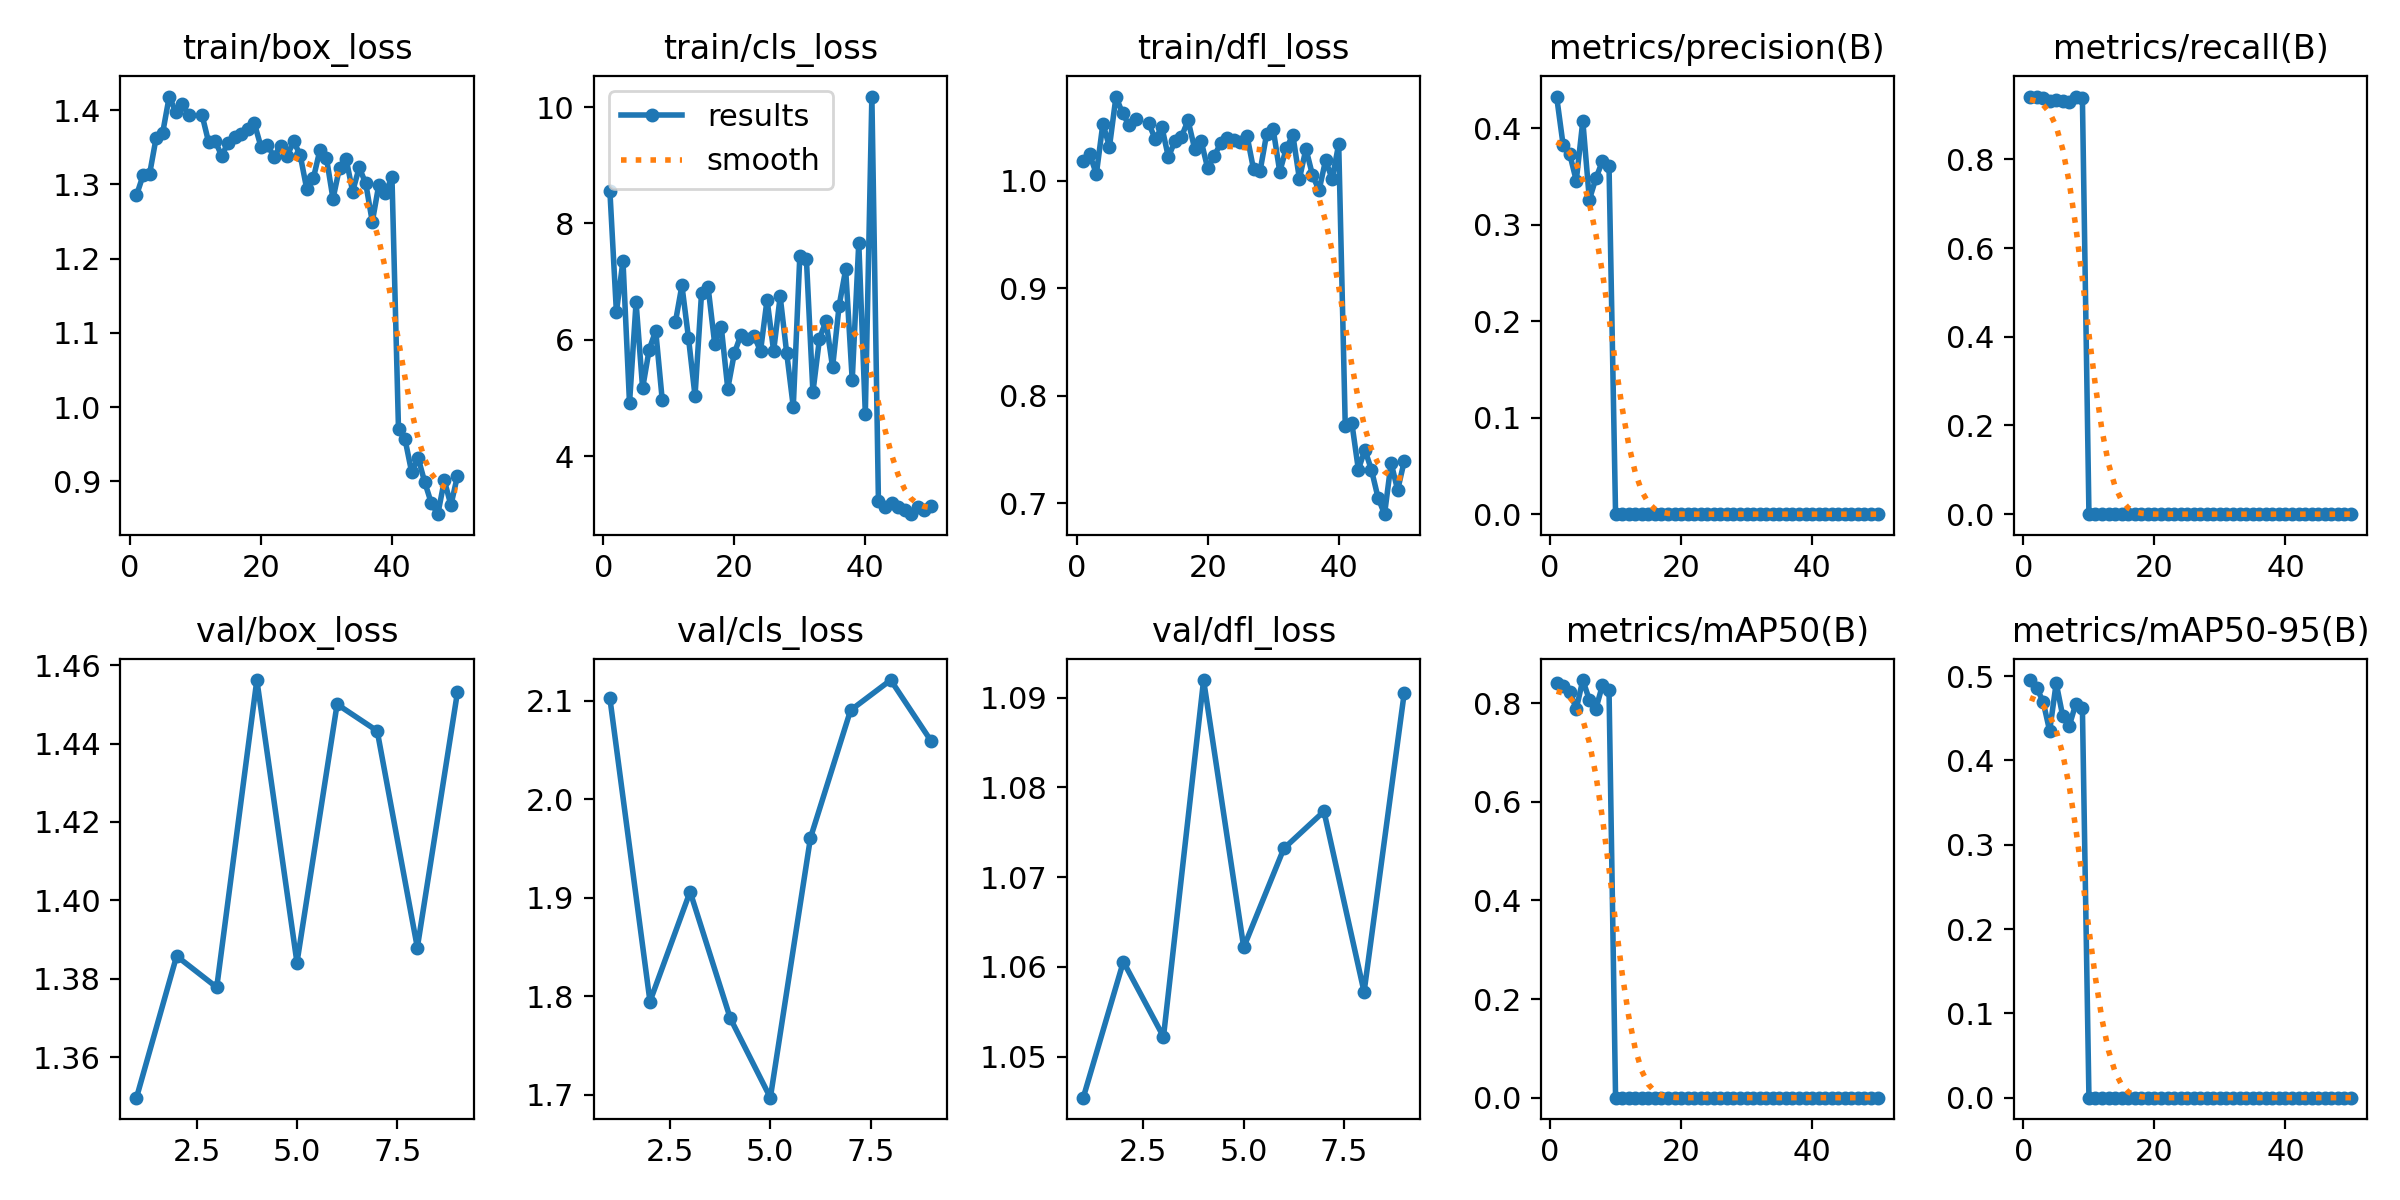

In [11]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / f"student_it{it+1}" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / f"student_it{it+1}" / "results.png"
img = Image.open(results_img)
display(img)

# Final Model Evaluation 

In [12]:
print("\nEvaluating …")
model   = YOLO(str(teacher_weights))
results = model.val(
    data=str(teacher_data_yaml_path),
    imgsz=640,
    batch=4,
    device=DEVICE,   # use same DEVICE string as before
    verbose=True
)

# Extract metrics depending on Ultralytics version
try:
    # new API
    metrics = results.results_dict
    print("\nValidation metrics")
    print(f"Precision (mP)   : {metrics.get('metrics/precision(B)', 0):.4f}")
    print(f"Recall (mR)      : {metrics.get('metrics/recall(B)', 0):.4f}")
    print(f"mAP@0.50         : {metrics.get('metrics/mAP50(B)', 0):.4f}")
    print(f"mAP@0.50:0.95    : {metrics.get('metrics/mAP50-95(B)', 0):.4f}")
except Exception as e:
    print("Could not parse metrics from results object:", e)
    print(results)

# import random, matplotlib.pyplot as plt

# # pick from test or valid images
# cands = list((WORK/"0_yolo_split"/"test"/"images").glob(".")) or list((WORK/"0_yolo_split"/"valid"/"images").glob("."))

# if cands:
#     imgs = random.sample(cands, min(4, len(cands)))  # pick up to 4 random images
#     fig, axes = plt.subplots(1, 4, figsize=(20, 6))
#     axes = axes.flatten()

#     for ax, img_path in zip(axes, imgs):
#         print("Visualising:", img_path.name)
#         pred = model.predict(
#             source=str(img_path),
#             imgsz=640,
#             conf=0.25,
#             device=DEVICE,
#             verbose=False
#         )[0]
#         ax.imshow(pred.plot()[:, :, ::-1])  # convert BGR to RGB
#         ax.axis("off")
#         ax.set_title(img_path.name, fontsize=10)

#     # hide unused axes if <4 images
#     for ax in axes[len(imgs):]:
#         ax.axis("off")

#     plt.tight_layout()
#     plt.show()

# else:
#     print("No images found for visualization.")


Evaluating …
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1713.2±192.4 MB/s, size: 90.1 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache... 39 images, 0 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]
invalid value encountered in less
invalid value encountered in less


                   all         39       3103      0.394      0.937       0.79      0.449
Speed: 1.6ms preprocess, 44.4ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/val

Validation metrics
Precision (mP)   : 0.3940
Recall (mR)      : 0.9375
mAP@0.50         : 0.7896
mAP@0.50:0.95    : 0.4487
